In [1]:
"""
🧠 Brain CT Classification – Model Training and Grad-CAM++ Visualization

This script is for classifying Brain CT images into:
- Aneurysm
- Cancer
- Tumor

It uses TensorFlow with tf.data pipelines, pretrained models from keras.applications, and Grad-CAM++ 
for visualizing where the model is focusing.

Steps:
- Load and preprocess images using tf.data
- Build and train a CNN using pretrained models
- Visualize model attention with Grad-CAM++
"""

# === Imports ===
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')

# === Config ===
IMG_SIZE = 299
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS = 20

# === Data Paths ===
train_dir = '/kaggle/input/brain-ct-medical-imaging-colorized-dataset/Computed Tomography (CT) of the Brain/dataset/train'
test_dir = '/kaggle/input/brain-ct-medical-imaging-colorized-dataset/Computed Tomography (CT) of the Brain/dataset/test'

2025-05-23 05:03:30.706987: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747976610.934342      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747976611.001457      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# List the class folders (aneurysm, cancer, tumor)
main_classes = os.listdir(train_dir)

# Show class names found
print(main_classes)

['aneurysm', 'cancer', 'tumor']


In [3]:
# Collect image info: class label and file path
data = []

for cls in main_classes:
    class_folder = os.path.join(train_dir, cls)
    if os.path.isdir(class_folder):
        # Get all images in the class folder
        image_files = glob(os.path.join(class_folder, '*.*'))  # jpg, png, etc.

        # Store class name and path for each image
        for img_path in image_files:
            data.append({
                'class': cls,
                'image_path': img_path
            })

# Convert to DataFrame for easy viewing or manipulation
df = pd.DataFrame(data)

# Preview dataset sample
df.head()

,class,image_path
0,aneurysm,/kaggle/input/brain-ct-medical-imaging-coloriz...
1,aneurysm,/kaggle/input/brain-ct-medical-imaging-coloriz...
2,aneurysm,/kaggle/input/brain-ct-medical-imaging-coloriz...
3,aneurysm,/kaggle/input/brain-ct-medical-imaging-coloriz...
4,aneurysm,/kaggle/input/brain-ct-medical-imaging-coloriz...


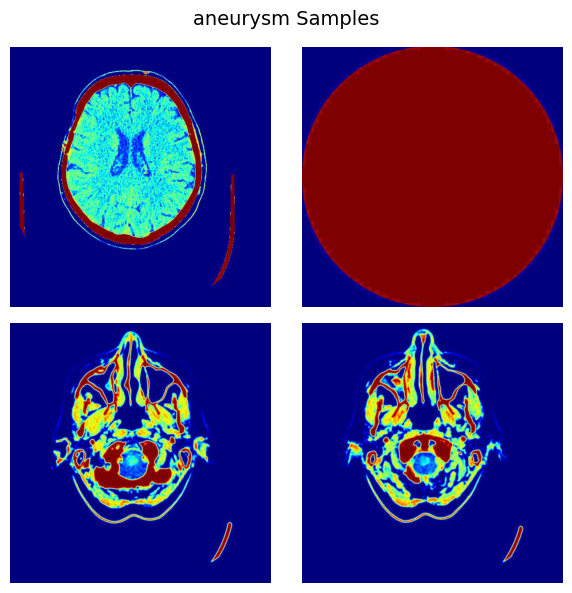

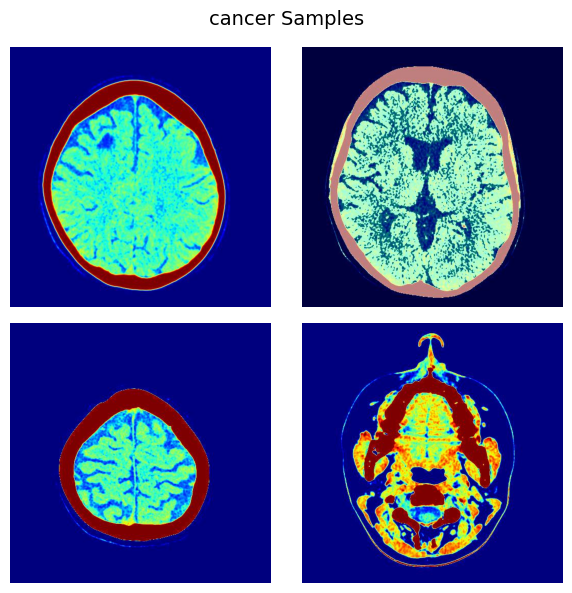

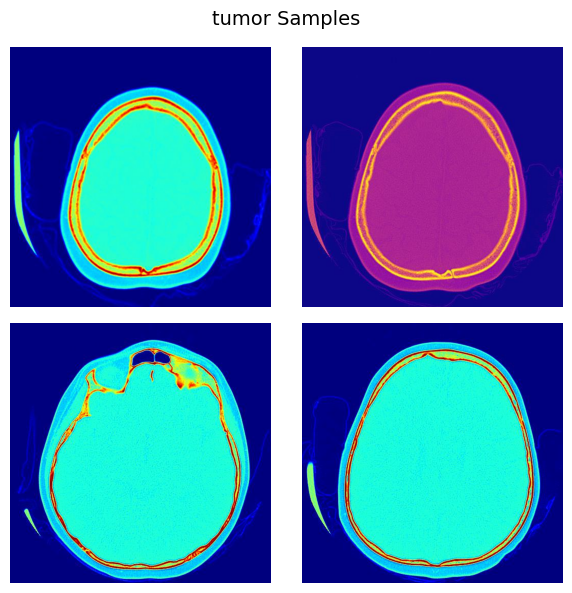

In [4]:
import random

def plot_random_grid(df, target_class, grid_size=2):
    """
    Show a grid of random images from a given class.
    
    Args:
        df (DataFrame): DataFrame with 'class' and 'image_path' columns.
        target_class (str): Class name to filter images.
        grid_size (int): Grid dimension (grid_size x grid_size).
    """
    # Pick random images of the class
    samples = df[df['class'] == target_class].sample(grid_size**2)

    # Create plot grid
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(6, 6))
    fig.suptitle(f'{target_class} Samples', fontsize=14)

    for i, ax in enumerate(axes.flat):
        img = Image.open(samples.iloc[i]['image_path'])
        ax.imshow(img)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Plot samples for each class in the dataset
for cls in df['class'].unique():
    plot_random_grid(df, cls)

In [5]:
# Define simple augmentation with random flip, rotation, zoom
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# Process function with augmentation applied
def process_path_aug(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img,  [IMG_SIZE, IMG_SIZE])
    img = data_augmentation(img)
    return img, label

def process_path(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img,  [IMG_SIZE, IMG_SIZE])
    img = img / 255.0
    return img, label

I0000 00:00:1747976626.249938      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [6]:
def get_filepaths_and_labels(data_dir):
    class_names = sorted(os.listdir(data_dir))
    class_indices = {name: idx for idx, name in enumerate(class_names)}

    file_paths = []
    labels = []

    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        for image in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, image))
            labels.append(class_indices[class_name])

    return tf.convert_to_tensor(file_paths), tf.convert_to_tensor(labels)

def prepare_dataset(file_paths, labels, aug=False):
    ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    if aug:
        ds = ds.map(process_path_aug, num_parallel_calls=AUTOTUNE)
    else:
        ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)
    return ds

In [7]:
from sklearn.model_selection import train_test_split

# Load data paths and labels
file_paths, labels = get_filepaths_and_labels(train_dir)
test_paths, test_labels = get_filepaths_and_labels(test_dir)

# Split with sklearn
train_paths, val_paths, train_labels, val_labels = train_test_split(
    file_paths.numpy(), labels.numpy(), test_size=0.2, stratify=labels.numpy(), random_state=42)

# Convert back to tensor
train_paths, val_paths = tf.convert_to_tensor(train_paths), tf.convert_to_tensor(val_paths)
train_labels, val_labels = tf.convert_to_tensor(train_labels), tf.convert_to_tensor(val_labels)

In [8]:
# Prepare datasets
train_ds = prepare_dataset(train_paths, train_labels, aug=False).shuffle(1000).batch(32).prefetch(AUTOTUNE)
val_ds   = prepare_dataset(val_paths, val_labels).batch(32).prefetch(AUTOTUNE)
test_ds = prepare_dataset(test_paths, test_labels).batch(32).prefetch(AUTOTUNE)

In [9]:
from tensorflow.keras.applications import InceptionResNetV2

# Load pretrained EfficientNetV2B3 without the classification head
base_model = InceptionResNetV2(
    include_top=False,         # Remove original classifier
    weights='imagenet',        # Use ImageNet pretrained weights
    input_shape=(299, 299, 3), # Input size must match your data
    pooling='avg'              # Global average pooling for feature vector
)

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [10]:
# Enable training for the entire model first
base_model.trainable = False

# Freeze all layers except the last 5 for fine-tuning
for layer in base_model.layers[-5:]:
    layer.trainable = True

In [11]:
x = Dense(256, activation='relu')(base_model.output)
x = Dropout(0.3)(x)
outputs = Dense(len(main_classes), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Low LR for fine-tuning
    loss='sparse_categorical_crossentropy',                 # Suitable loss for integer labels
    metrics=['accuracy']                                     # Track accuracy metric
)

In [13]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[
        # tf.keras.callbacks.ModelCheckpoint("/kaggle/working/model_best.h5", save_best_only=True),  # Save best model
        tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)    # Stop early if no improvement
    ]
)

Epoch 1/10


I0000 00:00:1747976669.255980      62 service.cc:148] XLA service 0x79806c003fb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747976669.256996      62 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747976673.860146      62 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/65 ━━━━━━━━━━━━━━━━━━━━ 48:43 46s/step - accuracy: 0.4062 - loss: 1.1609

I0000 00:00:1747976684.377733      62 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


65/65 ━━━━━━━━━━━━━━━━━━━━ 92s 723ms/step - accuracy: 0.5632 - loss: 0.9664 - val_accuracy: 0.7606 - val_loss: 0.6103
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 14s 201ms/step - accuracy: 0.8879 - loss: 0.5319 - val_accuracy: 0.9170 - val_loss: 0.3918
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 14s 201ms/step - accuracy: 0.9473 - loss: 0.3483 - val_accuracy: 0.9672 - val_loss: 0.2540
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 14s 201ms/step - accuracy: 0.9620 - loss: 0.2506 - val_accuracy: 0.9826 - val_loss: 0.1781
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 14s 201ms/step - accuracy: 0.9707 - loss: 0.1946 - val_accuracy: 0.9865 - val_loss: 0.1346
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 14s 201ms/step - accuracy: 0.9860 - loss: 0.1477 - val_accuracy: 0.9865 - val_loss: 0.1001
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 14s 201ms/step - accuracy: 0.9812 - loss: 0.1215 - val_accuracy: 0.9865 - val_loss: 0.0796
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 14s 202ms/step - accuracy: 0.9862 - loss: 0.0990 - val_accuracy: 0.994

In [14]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 1.0000 - loss: 0.0262
Test Accuracy: 1.00


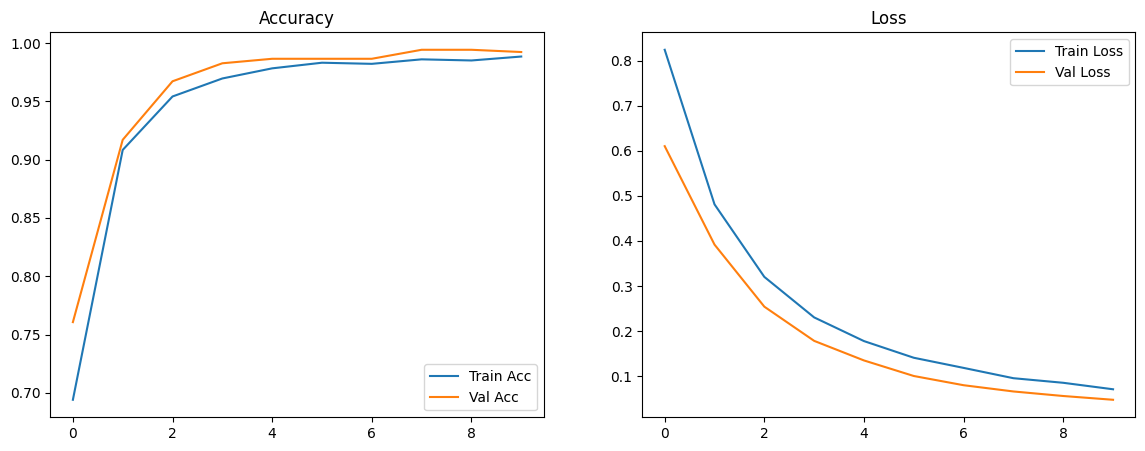

In [15]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()

In [ ]:
!pip install tf_keras_vis

In [17]:
def overlay_heatmap(img, cam, alpha=0.5, colormap=cv2.COLORMAP_JET):
    heatmap = np.uint8(255 * cam[0])  # cam is (1, H, W), take [0]
    heatmap = cv2.resize(heatmap, (img.shape[2], img.shape[1]))
    heatmap = cv2.applyColorMap(heatmap, colormap)
    superimposed_img = heatmap * alpha + img[0].astype(np.uint8)
    return superimposed_img

def plot_cam_comparison(original, gradcam_heatmap):
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))

    axs[0].imshow(original)
    axs[0].axis('off')
    axs[0].set_title("Original Image")

    axs[1].imshow(gradcam_heatmap.astype(np.uint8))
    axs[1].axis('off')
    axs[1].set_title("Grad-CAM")

    plt.tight_layout()
    plt.show()

In [18]:
from tensorflow.keras.preprocessing import image
img_path = '/kaggle/input/brain-ct-medical-imaging-colorized-dataset/Computed Tomography (CT) of the Brain/dataset/test/aneurysm/3_11.jpg'
sample_image,_ = process_path(img_path, 0)
sample_image = tf.expand_dims(sample_image, axis=0)


# Convert Tensor to NumPy before using .max()
img_array = sample_image[0].numpy()  # Convert to NumPy

if img_array.max() <= 1.0:
    display_img = (img_array * 255).astype(np.uint8)
else:
    display_img = img_array.astype(np.uint8)

In [19]:
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

replace2linear = ReplaceToLinear()
gradcam = Gradcam(model, model_modifier=replace2linear)
score = CategoricalScore([0])  
cam_gc = gradcam(score, seed_input=sample_image, penultimate_layer='conv_7b_ac', training=False)

heatmap_gc = overlay_heatmap(np.expand_dims(display_img, 0), cam_gc)

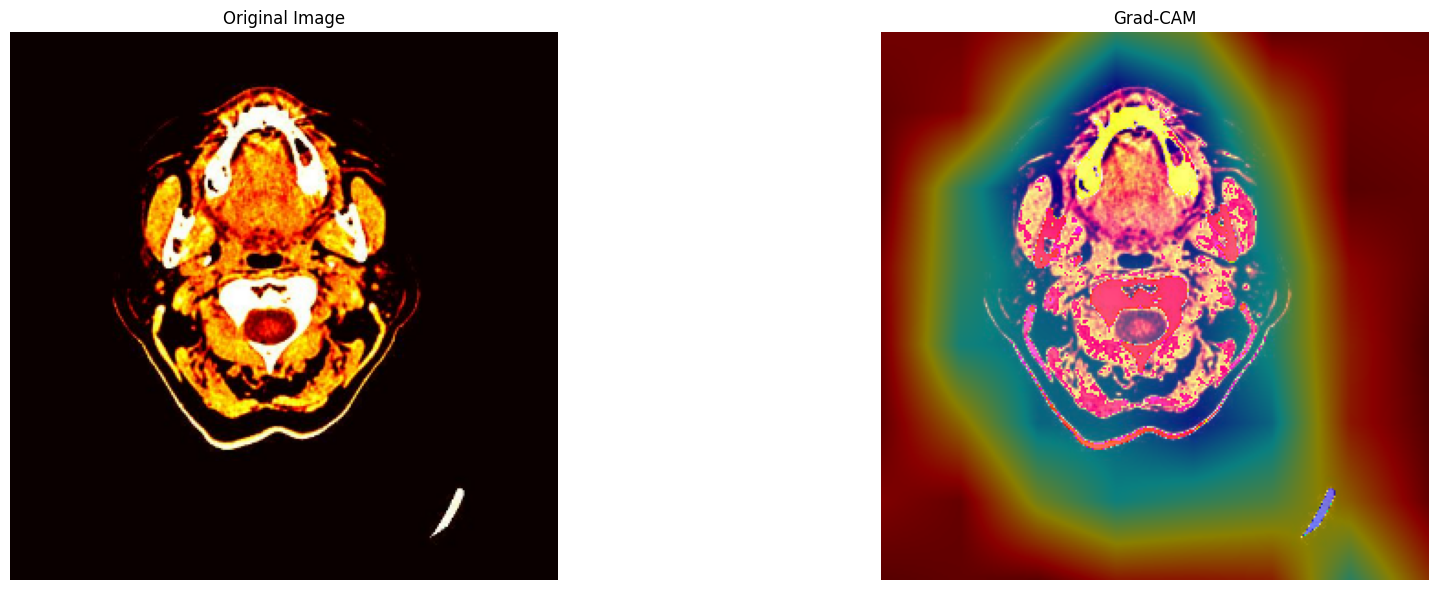

In [20]:
plot_cam_comparison(display_img, heatmap_gc)